In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)

Mounted at /content/gdrive


In [ ]:
pip install scikit-optimize

In [ ]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set_theme(style = "darkgrid")
%matplotlib inline


from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model


from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.layers import *
from keras import backend


from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import cross_val_score



from sklearn.model_selection import GridSearchCV
from hyperopt import STATUS_OK
import lightgbm as lgb
from hyperopt import fmin, tpe, Trials

import numpy as np
from hyperopt import hp, tpe, fmin,STATUS_OK,Trials

from skopt import BayesSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import  mean_squared_error, r2_score,plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score,precision_score, recall_score,f1_score, confusion_matrix
from matplotlib import pyplot
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense





In [ ]:
credit_smb= pd.read_csv('gdrive/My Drive/Thesis_Research_LJMU/creditcard.csv')
credit_smb.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [ ]:
credit_smb.shape

(284807, 31)

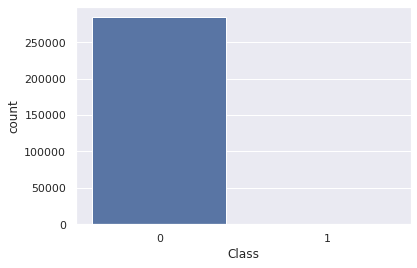

In [ ]:
sns.countplot('Class', data= credit_smb)

In [ ]:
X = credit_smb.drop(['Class'], axis =1)
y = credit_smb['Class']

In [ ]:
X_train_ada, y_train_ada = ADASYN().fit_resample(X, y)
y_resample_ada=pd.DataFrame(y_train_ada)
X_resample_ada=pd.DataFrame(X_train_ada)

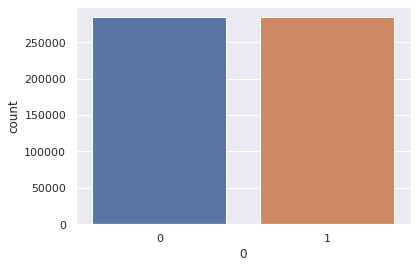

In [ ]:
sns.countplot(y_resample_ada.iloc[:,0])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resample_ada, y_resample_ada, test_size = 0.3, random_state=142)

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X = X_train
y = y_train
X_val = X_test
y_val = y_test

In [ ]:
units_options = np.arange(32, 1024 + 1, 32, dtype=int)
dropout_options = np.arange(.20,.75 + 0.01, 0.025, dtype=float)
batchsize_options = np.arange(32, 128 + 1, 32, dtype=int)

In [ ]:
space = { 
    #'choice': hp.choice('num_layers',
                            #[ {'layers':'two', },
                              #{'layers':'three',
                                    #'units3': hp.choice('units3', units_options), 
                                    #'dropout3': hp.choice('dropout3', dropout_options)}
                            #]),

            'units1': hp.choice('units1', units_options),
            'units2': hp.choice('units2', units_options),

            'dropout1': hp.choice('dropout1', dropout_options),
            'dropout2': hp.choice('dropout2', dropout_options),

            'batch_size' : hp.choice('batch_size', batchsize_options),

            'nb_epochs' :  10,
            'optimizer': hp.choice('optimizer',['adadelta','adam','rmsprop']),
            'activation': 'relu'
        }

In [ ]:
def f_nn(params):   

    model = Sequential()
    model.add(Dense(params['units1'], kernel_initializer = "he_normal", input_dim = X.shape[1])) 
    
    model.add(Dropout(params['dropout1']))
    #model.add(Activation(params['activation']))
    model.add(Dense(params['units2'],params['activation']))
    model.add(Dense(params['units2'],params['activation']))  
    #model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout2']))

    #if params['choice']['layers']== 'three':
        #model.add(Dense(units=params['choice']['units3'], kernel_initializer = "he_normal")) 
        #model.add(Activation(params['activation']))
        #model.add(Dropout(params['choice']['dropout3']))    

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'])

    model.fit(X, y, epochs=params['nb_epochs'], batch_size=params['batch_size'], verbose = 0)

    pred_auc = model.predict_proba(X_val, batch_size = 10, verbose = 0)

    
    yhat_classes = model.predict_classes(X_val, verbose=0)
    acc = accuracy_score(y_val, yhat_classes)
    print("Accuracy: %.5f" % (acc))

    return {'loss': acc, 'status': STATUS_OK}

In [ ]:
trials = Trials()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=5, trials=trials)
print('\nBest params found:\n', best)

Accuracy: 0.96395
Accuracy: 0.99850
Accuracy: 0.99705
Accuracy: 0.97528
Accuracy: 0.98243
100%|██████████| 5/5 [1:02:32<00:00, 750.55s/it, best loss: 0.963953242977067]

Best params found:
 {'batch_size': 1, 'dropout1': 13, 'dropout2': 14, 'optimizer': 0, 'units1': 27, 'units2': 24}


In [ ]:
print(units_options)
print(dropout_options)
print(batchsize_options)

[  32   64   96  128  160  192  224  256  288  320  352  384  416  448
  480  512  544  576  608  640  672  704  736  768  800  832  864  896
  928  960  992 1024]
[0.2   0.225 0.25  0.275 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475
 0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75 ]
[ 32  64  96 128]


In [ ]:
input_n = X_train.shape[1]
model = Sequential()

model.add(Dense(896, input_shape=(input_n,), kernel_initializer='he_normal' ,activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(800, activation='relu'))
model.add(Dense(800, activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))


model.summary()

model.compile(loss='binary_crossentropy', optimizer='adadelta', 
              metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.3)
print(history.history.keys())

#return model

#_,accuracy = model.evaluate(X,y)
#print('Accuracy: %2f' % (accuracy*100))

yhat_probs = model.predict(X_val, verbose=0)

yhat_classes = model.predict_classes(X_val, verbose=0)

yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]


accuracy = accuracy_score(y_val, yhat_classes)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_val, yhat_classes)
print('Precision: %f' % precision)

recall = recall_score(y_val, yhat_classes)
print('Recall: %f' % recall)

f1 = f1_score(y_val, yhat_classes)
print('F1 score: %f' % f1)

auc = roc_auc_score(y_val, yhat_probs)
print('ROC AUC: %f' % auc)

matrix = confusion_matrix(y_val, yhat_classes)
print(matrix)


tpr = recall_score(y_test, yhat_classes)
tnr = recall_score(y_test, yhat_classes, pos_label = 0) 
fpr = 1 - tnr
fnr = 1 - tpr

print('False Positive rate =%.3f' % (fpr))
print('True Positive Rate = %.3f' % (tpr))
print('False Negative rate =%.3f' % (fnr))
print('True Negative Rate = %.3f' % (tnr))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 896)               27776     
_________________________________________________________________
dense_21 (Dense)             (None, 800)               717600    
_________________________________________________________________
dense_22 (Dense)             (None, 800)               640800    
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 801       
Total params: 1,386,977
Trainable params: 1,386,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
4354/4354 [==============================] - 151s 34ms/step - loss: 0.4986 - accuracy: 0.8460 - val_loss: 0.2503 - val_accuracy: 0.9230
Epoch 2/10
4354/4354 [==============================] - 148s 34ms/step - loss: 0.2239 - accurac

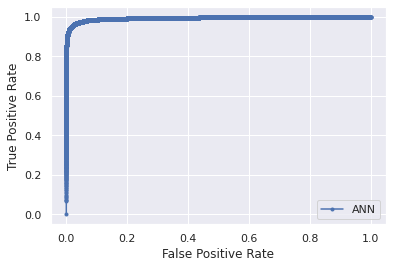

In [ ]:
ann_fpr, ann_tpr, _ = roc_curve(y_test, yhat_probs)
pyplot.plot(ann_fpr, ann_tpr, marker='.', label='ANN')


pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()

pyplot.show()

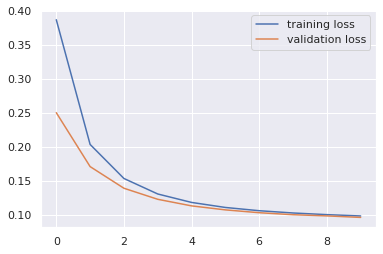

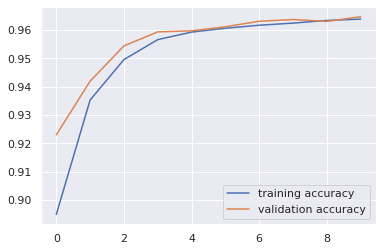

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

plt.figure()
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.legend()

plt.show()

In [ ]:
input_n = X_train.shape[1]
model = Sequential()

model.add(Dense(896, input_shape=(input_n,), kernel_initializer='he_normal' ,activation='relu'))
model.add(Dropout(0.525))
model.add(Dense(800, activation='relu'))
model.add(Dense(800, activation='relu'))
model.add(Dropout(0.55))
model.add(Dense(1, activation='sigmoid'))


model.summary()

model.compile(loss='binary_crossentropy', optimizer='adadelta', 
              metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.3)
print(history.history.keys())

#return model

#_,accuracy = model.evaluate(X,y)
#print('Accuracy: %2f' % (accuracy*100))

yhat_probs = model.predict(X_val, verbose=0)

yhat_classes = model.predict_classes(X_val, verbose=0)

yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]


accuracy = accuracy_score(y_val, yhat_classes)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_val, yhat_classes)
print('Precision: %f' % precision)

recall = recall_score(y_val, yhat_classes)
print('Recall: %f' % recall)

f1 = f1_score(y_val, yhat_classes)
print('F1 score: %f' % f1)

auc = roc_auc_score(y_val, yhat_probs)
print('ROC AUC: %f' % auc)

matrix = confusion_matrix(y_val, yhat_classes)
print(matrix)


tpr = recall_score(y_test, yhat_classes)
tnr = recall_score(y_test, yhat_classes, pos_label = 0) 
fpr = 1 - tnr
fnr = 1 - tpr

print('False Positive rate =%.3f' % (fpr))
print('True Positive Rate = %.3f' % (tpr))
print('False Negative rate =%.3f' % (fnr))
print('True Negative Rate = %.3f' % (tnr))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 896)               27776     
_________________________________________________________________
dropout_10 (Dropout)         (None, 896)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 800)               717600    
_________________________________________________________________
dense_26 (Dense)             (None, 800)               640800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 800)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 801       
Total params: 1,386,977
Trainable params: 1,386,977
Non-trainable params: 0
____________________________________________

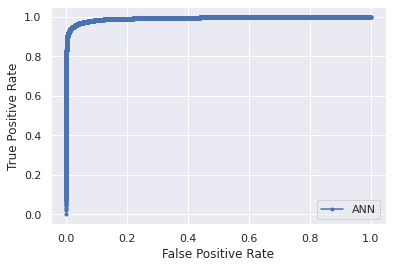

In [ ]:
ann_fpr, ann_tpr, _ = roc_curve(y_test, yhat_probs)
pyplot.plot(ann_fpr, ann_tpr, marker='.', label='ANN')


pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()

pyplot.show()

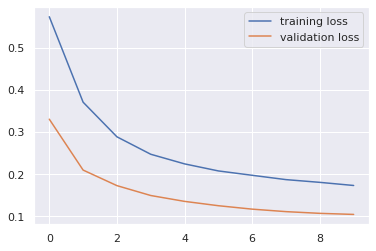

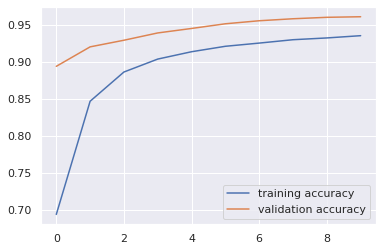

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

plt.figure()
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.legend()

plt.show()